 # <font color = #254117>[EEP 147]: ESG Analysis Lecture Graphs</font>

<div style="width:image width px; font-size:80%; text-align:center;"><img src="big_creek.jpg" alt="alternate text" width="500" height="height" style="padding-bottom:0.5em;" />Big Creek Hydroelectric Project - Southern California Edison</div>

This notebook can be utilized for analysis of the Electricity Strategy Game. This notebook builds on the Round 0 notebook by allowing carbon prices to be adjusted in more of the function, including separately for each of Rounds 4, 5, and 6 in the NPV of expected profits function.

First on our agenda is to import **<font color = ##008700>dependencies</font>** -- packages in Python that add to the basic functions in Python -- same as before.

In [1]:
from datascience import *
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
%matplotlib inline
import numpy as np
import pandas as pd
from ipywidgets import interact, interactive, Dropdown, IntSlider
import ipywidgets as widgets
from functools import partial
from matplotlib.lines import Line2D
plt.style.use('fivethirtyeight')
plt.rcParams["figure.figsize"] = [10,6]

Next, let's select your portfolio. In the cell below, assign **section** to the section code (including quotes) that corresponds to your own according to the following table.

| Code | Section Time  |
|---------|---------------|
| "W8" | Wednesday 8am |
| "W9" | Wednesday 9am |
| "F2" | Friday 2pm |
| "F3" | Friday 3pm |


The variable **current_period** should contain the current round.

The variable **pab_periods** should contain each of the periods for which there was or will be a pay-as-bid auction.  This shouldn't change.

In [2]:
section = "W8"
current_period = 7
pab_periods = [1]

Next we import the demand forecasts.

In [3]:
demand_table = Table.read_table('demand.csv')

Next we import our Bids and Porfolios tables.

In [4]:
bids_mc = Table.read_table('Bids/MC_bids.csv').sort('PORTFOLIO')
ESG = Table.read_table('ESGPorfolios.csv')

In the following cell we will join the tables based on the column **Plant_ID**.  We will incorporate the actual bids of the rounds completed.

In [5]:
def get_bids(section):
    bids_all = bids_mc.copy()
    if current_period > 1:
        bids_all_df = bids_all.sort("PLANT_ID").to_df()
        bids_actual = Table.read_table('Bids/' + section + '_bids_' + str(current_period - 1) + '.csv').sort('PORTFOLIO')
        bids_actual_df = bids_actual.sort("PLANT_ID").to_df()
        for period_i in range(1,current_period):
            bids_all_df.loc[bids_all_df["PERIOD"] == period_i] = bids_actual_df.loc[bids_actual_df["PERIOD"] == period_i].values
        bids_all = Table.from_df(bids_all_df)
        
    joined_table_all = bids_all.join("PLANT_ID", ESG, "Plant_ID").sort("PLANT_ID")
    return(joined_table_all)

joined_table_all = get_bids(section)

Now, let's create a function to determine the price given the bids and demand.

In [6]:
def price_calc(input_table, demand, hour, period):
    #hour and period determine which bids are taken from joined_table
    joined_table = input_table.copy()
    sorted_table = joined_table.where("PERIOD", period).sort("PRICE" + str(hour), descending = False)
    price = 0
    sum_cap = 0
    for i in range(0,len(sorted_table['Capacity_MW'])):
        if sum_cap + sorted_table['Capacity_MW'][i] > demand:
            price = sorted_table['PRICE' + str(hour)][i]
            break
        else:
            sum_cap += sorted_table['Capacity_MW'][i]
            price = sorted_table['PRICE' + str(hour)][i]
    return price

Now, let's create a function to plot the market in a given hour and period.

In [7]:
energy_colors_dict = {'Bay Views' : '#EC5F67', 'Beachfront' : '#F29056', 'Big Coal' : '#F9C863', 'Big Gas' : '#99C794', 
                      'East Bay' : '#5FB3B3', 'Fossil Light' : '#6699CC', 'Old Timers' : '#C594C5'}

def find_x_pos(widths):
    cumulative_widths = [0]
    cumulative_widths.extend(np.cumsum(widths))
    half_widths = [i/2 for i in widths]
    x_pos = []
    for i in range(0, len(half_widths)):
        x_pos.append(half_widths[i] + cumulative_widths[i])
    return x_pos

def price_line_plot(price):
    plt.axhline(y=price, color='r', linewidth = 2)
    
def demand_plot(demand):
    plt.axvline(x=demand, color='r', linewidth = 2)
    
def adjust_bids_by_cp(input_table, hour, period, carbon_price):
    joined_table = input_table.copy()
    joined_table["Total_Var_Cost_USDperMWH"] += carbon_price * joined_table["Carbon_tonsperMWH"]
    joined_table["PRICE" + str(hour)] += carbon_price * joined_table["Carbon_tonsperMWH"]
    return(joined_table)
    
def user_defined_bids(input_table, hour, period, my_portfolio, def_my_bids, def_others_bids):
    joined_table = input_table.copy()
    joined_df = joined_table.to_df()
    if def_my_bids:
        joined_df.loc[(joined_df["Group"] == my_portfolio) & 
                      (joined_df["PERIOD"] == period), 
                      "PRICE" + str(hour)] =  list(globals()["bids_" + my_portfolio.replace(" ", "").lower()].values())
    if def_others_bids:
        for group in set(joined_table['Group']):
            if group != my_portfolio:
                joined_df.loc[(joined_df["Group"] == group) & 
                              (joined_df["PERIOD"] == period), 
                              "PRICE" + str(hour)] =  list(globals()["bids_" + group.replace(" ", "").lower()].values())
    joined_table = Table.from_df(joined_df)
    return(joined_table)

def market_plot(section, hour, period, carbon_price, my_portfolio, def_my_bids, def_others_bids):
    demand = demand_table.where("round", period).where("hour", hour)["load"].item()
    joined_table = get_bids(section)
    if period >= current_period:
        joined_table = adjust_bids_by_cp(joined_table, hour, period, carbon_price)
    joined_table = user_defined_bids(joined_table, hour, period, my_portfolio, def_my_bids, def_others_bids)
    
    sorted_joined_table = joined_table.where("PERIOD", period).sort("PRICE" + str(hour), descending = False)
    width = sorted_joined_table.column("Capacity_MW")
    height = sorted_joined_table.column('PRICE' + str(hour))
    x_vals = find_x_pos(width)
    colors_mapped = list(pd.Series(sorted_joined_table['Group']).map(energy_colors_dict))
    sorted_joined_table = sorted_joined_table.with_column('Color', colors_mapped)
    group_colors = sorted_joined_table.group("Group", lambda x: x).select("Group", "Color")
    group_colors["Color"] = group_colors.apply(lambda x: x[0], "Color")
    price = price_calc(sorted_joined_table, demand, hour, period)
    # Make the plot
    plt.figure(figsize=(9,6))
    plt.bar(x_vals, height, width=width, color=sorted_joined_table['Color'], edgecolor = "black")
    
    num_plants = len(width)
    height_mc = sorted_joined_table.column("Total_Var_Cost_USDperMWH")
    x_vec = np.zeros(num_plants * 2)
    h_vec = np.zeros(num_plants * 2)
    for i, (w, h) in enumerate(zip(width, height_mc)):
        h_vec[2*i] = h
        h_vec[2*i+1] = h
        if i == 0:
            x_vec[1] = w
        else: 
            x_vec[2*i] = x_vec[2*i - 1]
            x_vec[2*i + 1] = x_vec[2*i] + w
                   
    #x_vec = np.zeros(num_plants*2 + 2)
    #h_vec = np.zeros(num_plants*2 + 2)
    #for i, (w, h) in enumerate(zip(width, height_mc)):
    #    x_vec[2*i + 1] = x_vec[2*i]
    #    x_vec[2*i + 2] = x_vec[2*i + 1] + w
    #    h_vec[2*i + 1] = h
    #    h_vec[2*i + 2] = h
    #x_vec[-1] = x_vec[-2]
    
    
    line_mc = plt.plot(x_vec, h_vec, '--k', label='Marginal Cost', linewidth=2)
    
    patches = []
    for row in group_colors.rows:
        patches += [mpatches.Patch(color=row.item("Color"), label=row.item("Group"))]
    patches += line_mc
    plt.legend(handles=patches, bbox_to_anchor=(1.1,1))
    
    plt.title('Section ' + section + ', Round ' + str(period) + ', Hour ' + str(hour) + 
              '\ndemand = ' + str(demand) + ', price = ' + str(price))
    plt.xlabel('Capacity_MW')
    plt.ylabel('Price')
    price_line_plot(price)
    demand_plot(demand)
    #plt.ylim((0, 100))

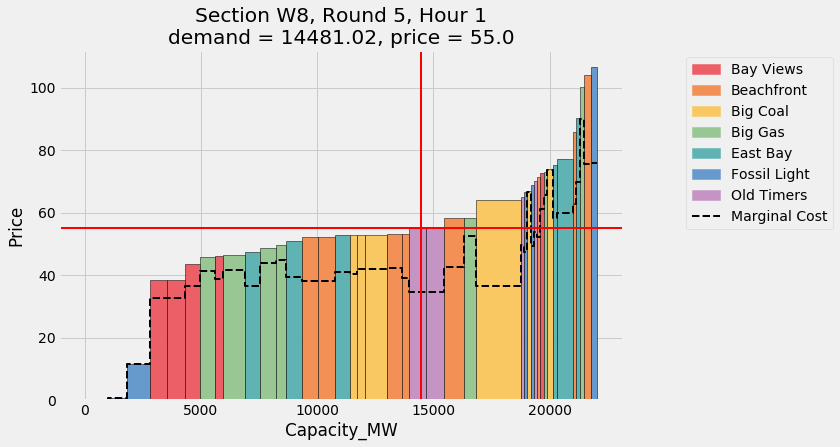

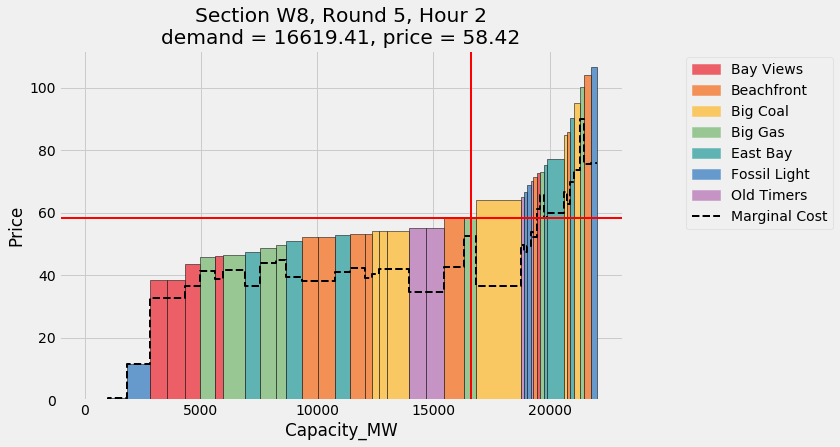

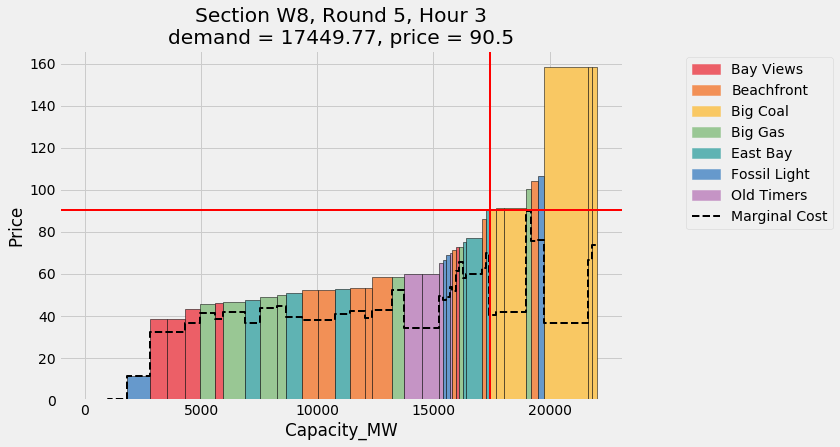

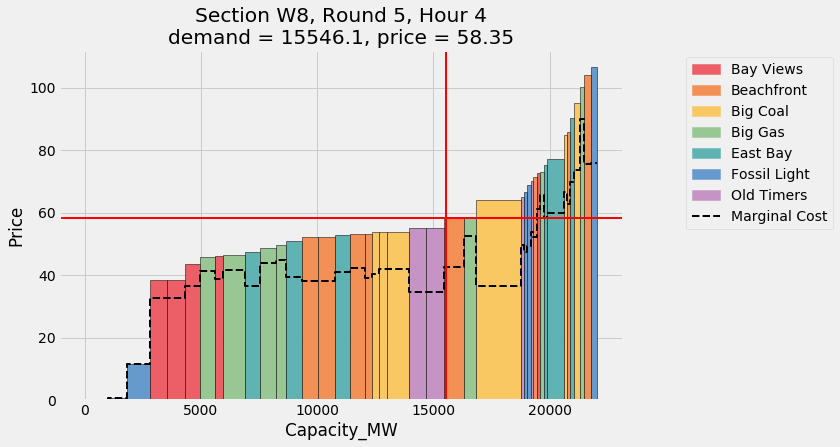

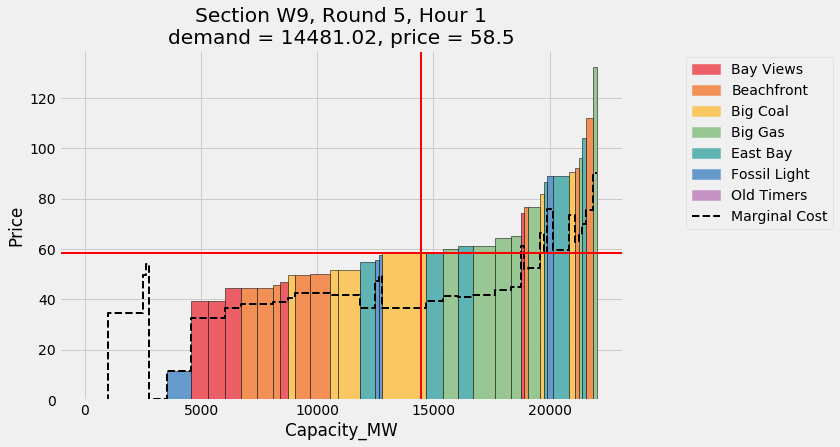

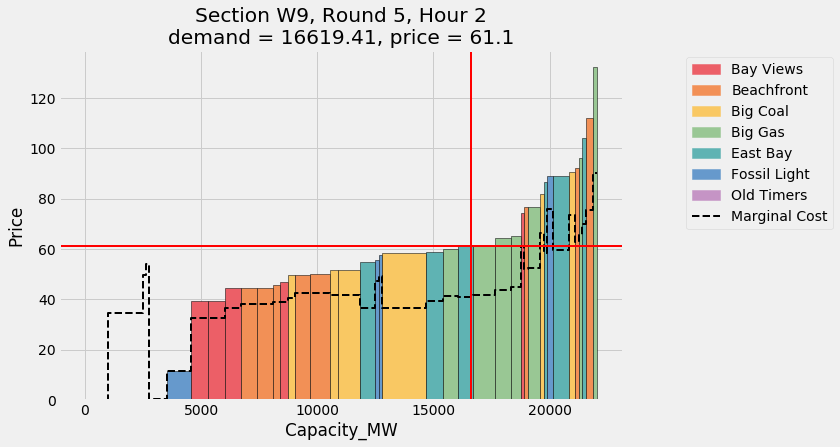

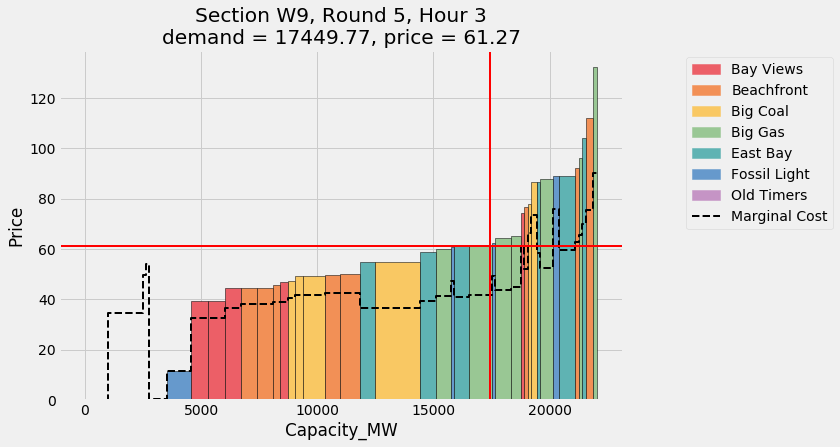

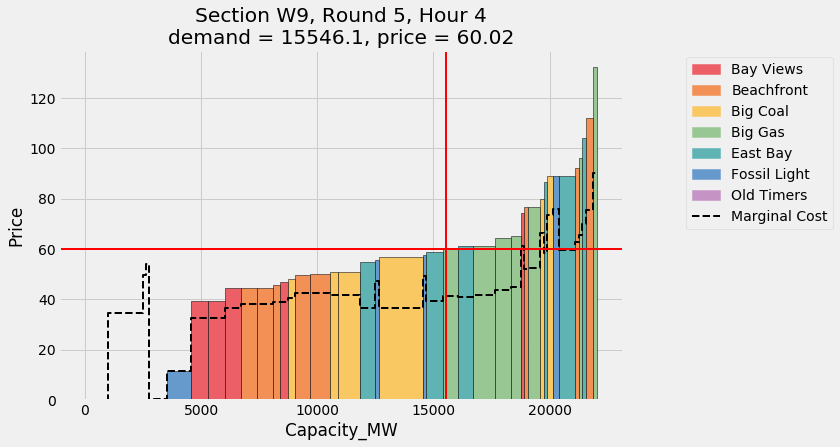

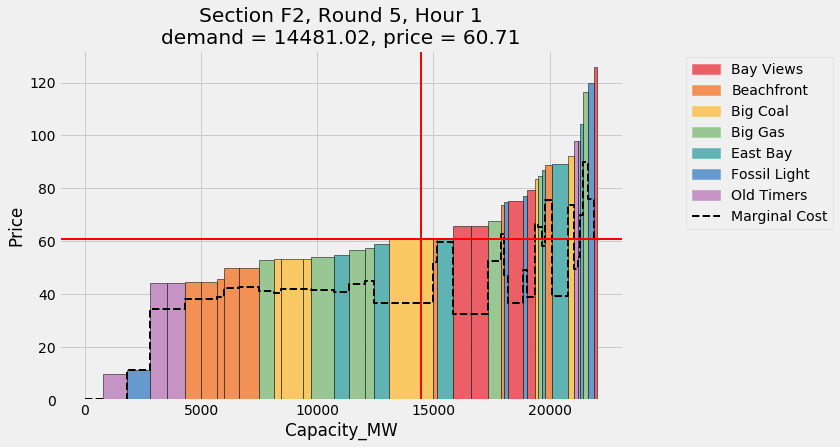

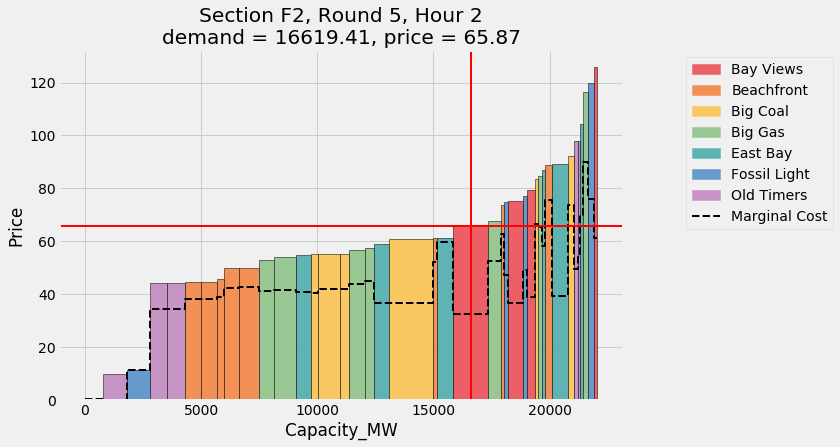

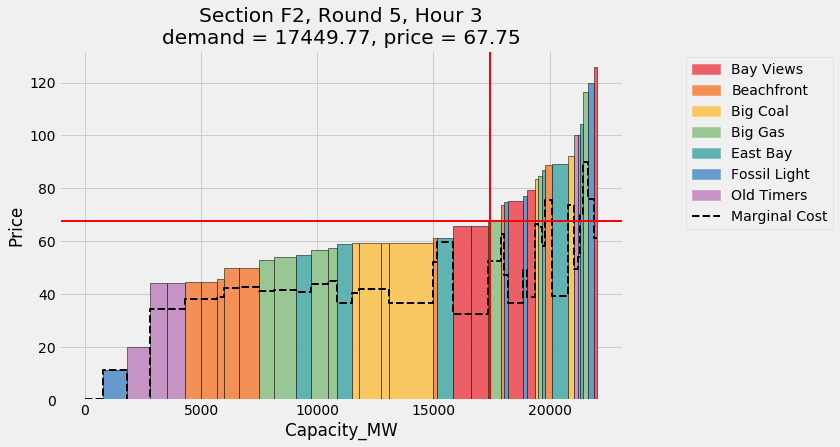

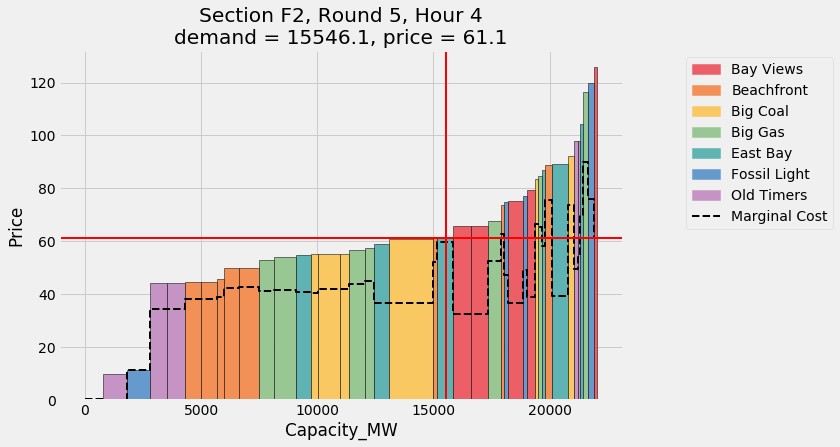

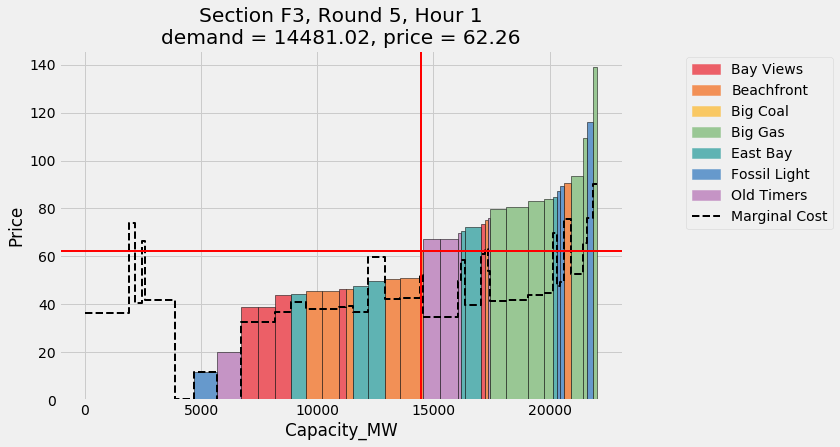

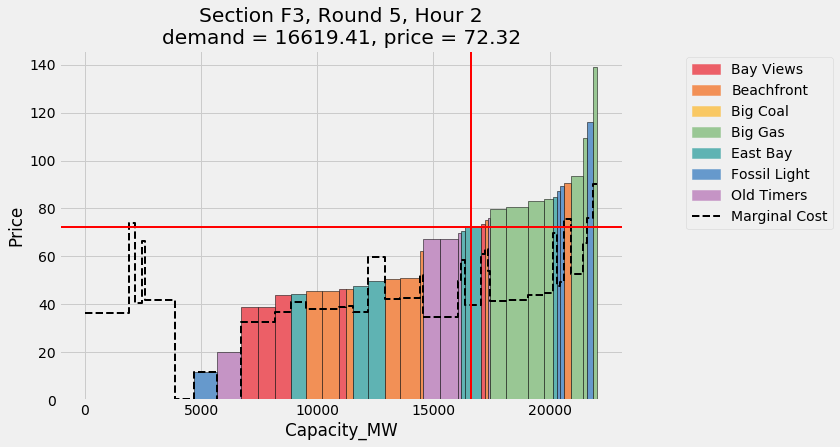

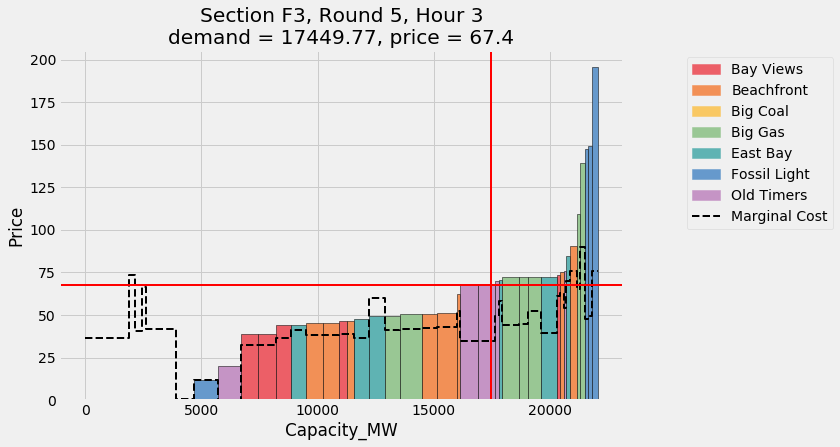

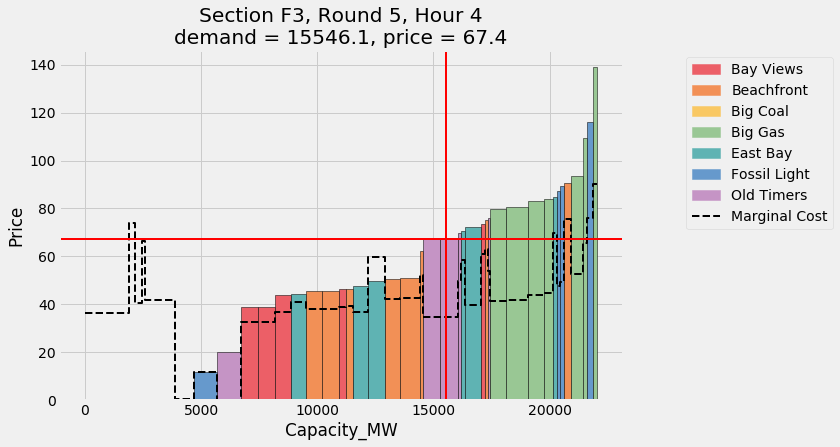

In [8]:
period=current_period - 1
for section in ["W8", "W9", "F2", "F3"]:
    for hour in range(1,5):
        market_plot(section = section,
                    hour = hour,
                    period = period,
                    carbon_price = 0,
                    my_portfolio = 'Bay Views',
                    def_my_bids = False,
                    def_others_bids = False)

Thanks for help from: Alec Kan, Alma Pineda, Aarish Irfan, Elaine Chien, Octavian Sima, and Eric Van Dusen.